In [ ]:
# Importing the necessary libraries
# !pip install opencv-python
# !pip install albumentations
# !pip install tensorflow

import os
import cv2
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage import exposure
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-07-02 16:12:27.103261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751472747.321160      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751472747.382085      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Dataset Loading

# from google.colab import drive
# drive.mount('/content/drive')

src_dir = "/kaggle/input/busi-dataset/Dataset BUSI"

In [ ]:
# Augmentation & preprocessing

IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 1

classes = ['normal', 'benign', 'malignant']
label_map = {'normal': 0, 'benign': 1, 'malignant': 2}

# --- Preprocessing Functions ---
def contrast_stretching(img):
    in_min = np.percentile(img, 2)
    in_max = np.percentile(img, 98)
    stretched = (img - in_min) * (255.0 / (in_max - in_min))
    return np.clip(stretched, 0, 255).astype(np.uint8)

def log_contrast_stretching(img, k=4):
    img = img.astype(np.float32) / 255.0
    stretched = np.log1p(k * img)
    stretched = stretched / stretched.max()
    return (stretched * 255).astype(np.uint8)

def apply_gamma_correction(img, gamma=2.0, c=1.0):
    img = img.astype(np.float32) / 255.0
    img = c * (img ** gamma)
    return (img * 255.0).clip(0, 255).astype(np.uint8)

def preprocess_image(img):
    img = contrast_stretching(img)
    img = log_contrast_stretching(img)
    img = apply_gamma_correction(img)
    return img

# --- Albumentations Transforms ---
train_transform = A.Compose([
    A.HorizontalFlip(p=0.9),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, p=0.3),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=25, p=0.5),
    A.Normalize(mean=0, std=1, max_pixel_value=255.0),
])

val_transform = A.Compose([
    A.Normalize(mean=0, std=1, max_pixel_value=255.0),
])

# --- Data Loading ---
def load_and_preprocess_data(src_dir):
    raw_images, raw_masks, raw_labels = [], [], []
    total_images = 0
    class_counts = {}

    for cls in classes:
        cls_path = os.path.join(src_dir, cls)
        image_files = [f for f in os.listdir(cls_path) if f.endswith('.png') and 'mask' not in f]
        class_counts[cls] = len(image_files)
        total_images += len(image_files)

        for file in tqdm(image_files, desc=f"Processing {cls}"):
            img_path = os.path.join(cls_path, file)
            mask_path = os.path.join(cls_path, file.replace('.png', '_mask.png'))

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            img = preprocess_image(img)

            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
                kernel = np.ones((3,3), np.uint8)
                mask = (mask > 0).astype(np.float32)
                mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
                mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            else:
                mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)

            raw_images.append(img)
            raw_masks.append(mask)
            raw_labels.append(label_map[cls])

    print(f"\nClass-wise counts:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count}")
    print(f"Total images: {total_images}")

    return np.array(raw_images), np.array(raw_masks), np.array(raw_labels)

# --- Apply Split and Augmentation ---
def apply_augmentations(X_raw, y_mask_raw, transform):
    X_aug, y_aug = [], []
    for img, mask in zip(X_raw, y_mask_raw):
        augmented = transform(image=np.expand_dims(img, axis=-1), mask=np.expand_dims(mask, axis=-1))
        X_aug.append(augmented['image'])
        y_aug.append(augmented['mask'])
    return np.array(X_aug), np.array(y_aug)

raw_images, raw_masks, raw_labels = load_and_preprocess_data(src_dir)

# Split
X_train_raw, X_val_raw, y_train_mask_raw, y_val_mask_raw, y_train_cls, y_val_cls = train_test_split(
    raw_images, raw_masks, raw_labels, test_size=0.2, random_state=42, stratify=raw_labels
)

# Augment
print("\nApplying training augmentations...")
X_train, y_train_mask = apply_augmentations(X_train_raw, y_train_mask_raw, train_transform)
print("Processing validation set...")
X_val, y_val_mask = apply_augmentations(X_val_raw, y_val_mask_raw, val_transform)

# Compute class weights
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_cls), y=y_train_cls)
class_weight_dict = dict(enumerate(class_weights_array))
class_weights_tensor = tf.constant(class_weights_array, dtype=tf.float32)

print("\nComputed class weights:", class_weight_dict)

/tmp/ipykernel_13/4155442757.py:38: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, p=0.3),
Processing malignant: 100%|██████████| 210/210 [00:05<00:00, 40.20it/s]



Class-wise counts:
normal: 133
benign: 437
malignant: 210
Total images: 780

Applying training augmentations...
Processing validation set...

Computed class weights: {0: 1.9622641509433962, 1: 0.5942857142857143, 2: 1.2380952380952381}


2025-07-02 16:13:07.119547: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
# Building Multi-Task U-Net Model

def conv_block(input_tensor, n_filters, dropout_rate=0.1):
    x = layers.Conv2D(n_filters, (3, 3), padding="same", kernel_initializer="he_normal")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(n_filters, (3, 3), padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def build_multi_task_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=3):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 16)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 32)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 64, dropout_rate=0.2)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 128, dropout_rate=0.2)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = conv_block(p4, 256, dropout_rate=0.3)

    # Decoder for segmentation with Attention
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    att_c4 = attention_gate(c4, u6, 64)  # attention-modified skip connection
    u6 = layers.concatenate([u6, att_c4])
    c6 = conv_block(u6, 128, dropout_rate=0.2)

    # Decoder level 2
    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    att_c3 = attention_gate(c3, u7, 32)
    u7 = layers.concatenate([u7, att_c3])
    c7 = conv_block(u7, 64, dropout_rate=0.2)

    # Decoder level 3
    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    att_c2 = attention_gate(c2, u8, 16)
    u8 = layers.concatenate([u8, att_c2])
    c8 = conv_block(u8, 32, dropout_rate=0.1)

    # Decoder level 4
    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    att_c1 = attention_gate(c1, u9, 8)
    u9 = layers.concatenate([u9, att_c1])
    c9 = conv_block(u9, 16, dropout_rate=0.1)


    # Segmentation output
    seg_output = layers.Conv2D(1, (1, 1), activation='sigmoid', name='segmentation')(c9)

    # Classification head
    gap = layers.GlobalAveragePooling2D()(c5)
    dense1 = layers.Dense(256, activation='relu')(gap)
    bn1 = layers.BatchNormalization()(dense1)
    drop1 = layers.Dropout(0.5)(bn1)
    dense2 = layers.Dense(128, activation='relu')(drop1)
    drop2 = layers.Dropout(0.3)(dense2)
    class_output = layers.Dense(num_classes, activation='softmax', name='classification')(drop2)

    model = models.Model(inputs=[inputs], outputs=[seg_output, class_output])
    return model

def weighted_sparse_categorical_crossentropy(class_weights_tensor):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        weights = tf.gather(class_weights_tensor, y_true)
        unweighted_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        weighted_loss = unweighted_loss * weights
        return tf.reduce_mean(weighted_loss)
    return loss_fn

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    denom = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return 1 - (2. * intersection + smooth) / (denom + smooth)

def combined_segmentation_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def attention_gate(x, g, inter_channels):
    theta_x = layers.Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = layers.Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(g)
    add = layers.Add()([theta_x, phi_g])
    relu = layers.Activation('relu')(add)
    psi = layers.Conv2D(1, (1, 1), padding='same')(relu)
    sigmoid = layers.Activation('sigmoid')(psi)
    # Multiply attention map with the encoder features
    out = layers.Multiply()([x, sigmoid])
    return out

model = build_multi_task_unet()

model.compile(
   optimizer=Adam(learning_rate=0.001),
    loss={
        'segmentation': combined_segmentation_loss,
        'classification': weighted_sparse_categorical_crossentropy(class_weights_tensor)
    },
    loss_weights={'segmentation': 0.6, 'classification': 1.0},
    metrics={
        'segmentation': ['accuracy'],
        'classification': ['accuracy']
    }
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 256, 256, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 256, 256, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 128, 128, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ re_lu_3[0][0]          │
│ (MaxPooling2D)       

 Total params: 2,068,928 (7.89 MB)

 Trainable params: 2,065,472 (7.88 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [ ]:
# Training the model:

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('multi_task_unet.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=0),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=7, min_lr=1e-6, verbose=1)
]

# Model Training
history = model.fit(
    X_train,
    {'segmentation': y_train_mask, 'classification': y_train_cls},
    validation_data=(X_val, {'segmentation': y_val_mask, 'classification': y_val_cls}),
    epochs=50,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)

_, test_predictions = model.predict(X_val, verbose=1)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_accuracy = accuracy_score(y_val_cls, test_predicted_labels)
print(f'Test accuracy: {test_accuracy*100:.2f}%')

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(16, 256, 256, 1))
  warnings.warn(msg)


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - classification_accuracy: 0.3446 - classification_loss: 1.4673 - loss: 2.3486 - segmentation_accuracy: 0.7131 - segmentation_loss: 1.4688

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)


39/39 ━━━━━━━━━━━━━━━━━━━━ 324s 8s/step - classification_accuracy: 0.3452 - classification_loss: 1.4664 - loss: 2.3464 - segmentation_accuracy: 0.7159 - segmentation_loss: 1.4666 - val_classification_accuracy: 0.1731 - val_classification_loss: 1.8835 - val_loss: 4.5199 - val_segmentation_accuracy: 0.3117 - val_segmentation_loss: 4.3948 - learning_rate: 0.0010
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 288s 7s/step - classification_accuracy: 0.3985 - classification_loss: 1.2757 - loss: 1.9920 - segmentation_accuracy: 0.8993 - segmentation_loss: 1.1939 - val_classification_accuracy: 0.2885 - val_classification_loss: 1.0750 - val_loss: 1.9799 - val_segmentation_accuracy: 0.7563 - val_segmentation_loss: 1.5086 - learning_rate: 0.0010
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 296s 8s/step - classification_accuracy: 0.3990 - classification_loss: 1.2617 - loss: 1.9175 - segmentation_accuracy: 0.9087 - segmentation_loss: 1.0930 - val_classification_accuracy: 0.3269 - val_classification_loss: 1.0395 - v

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 256, 256, 1))
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step
Test accuracy: 71.15%


In [ ]:
# Model Save & Best Model Loading:

## model.save("multi_task_U-Net_model.h5")

model = load_model(
    "multi_task_U-Net_model.h5",
    custom_objects={
        'combined_segmentation_loss': combined_segmentation_loss,
        'weighted_sparse_categorical_crossentropy': weighted_sparse_categorical_crossentropy(class_weights_tensor),
        'dice_loss': dice_loss,
    },
    compile=True
)

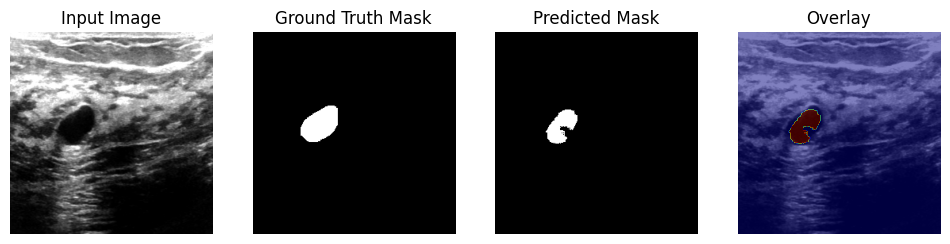

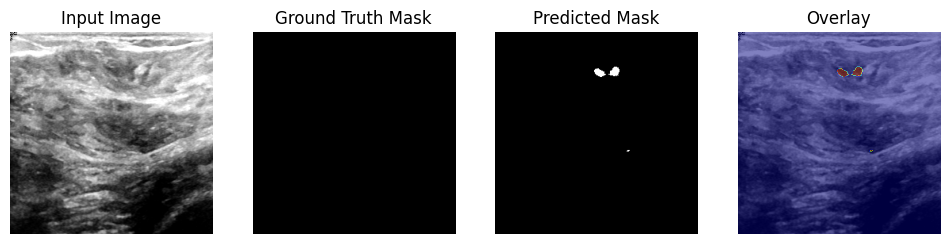

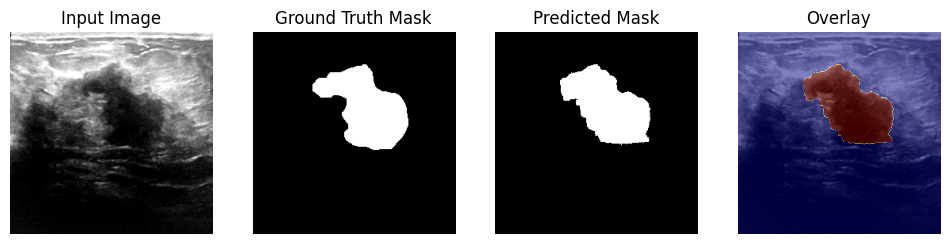

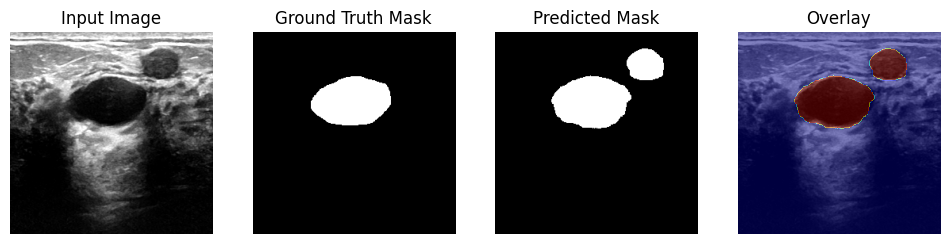

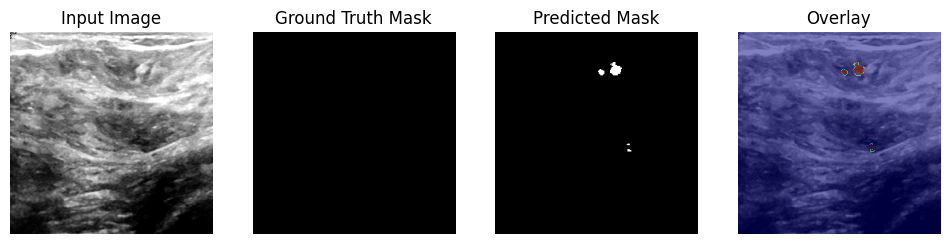

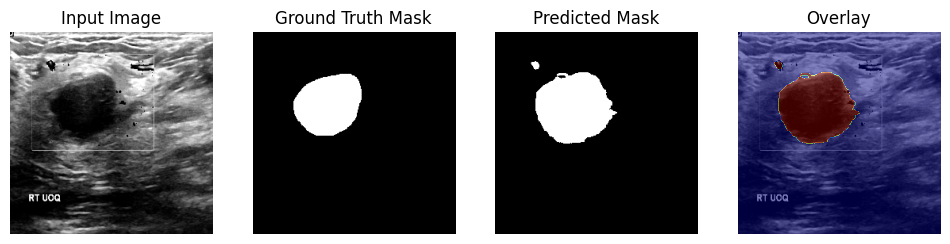

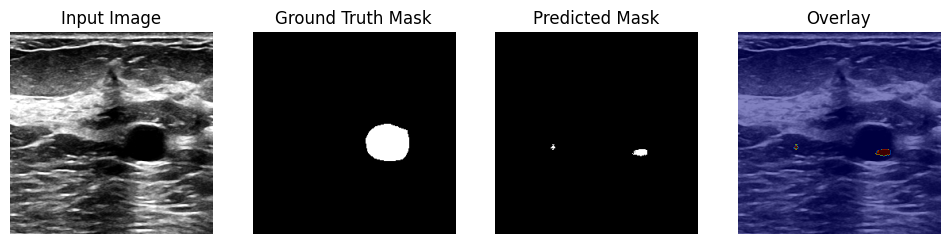

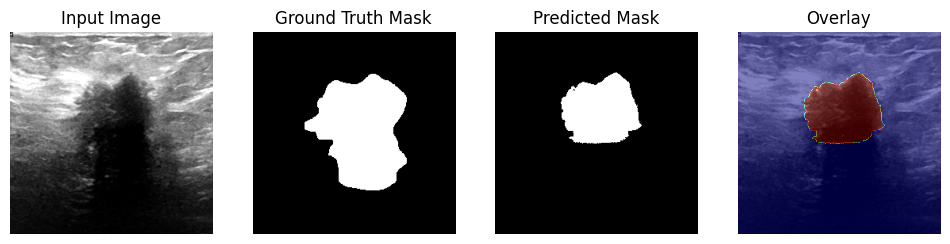

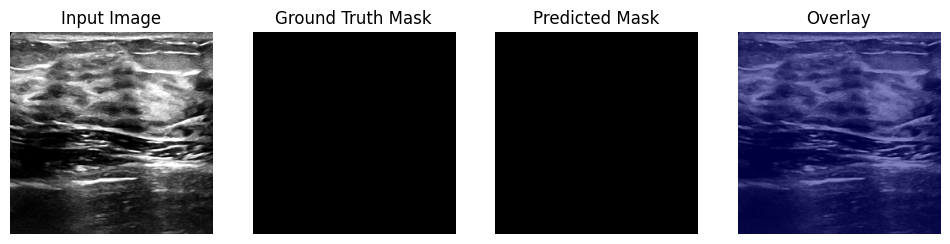

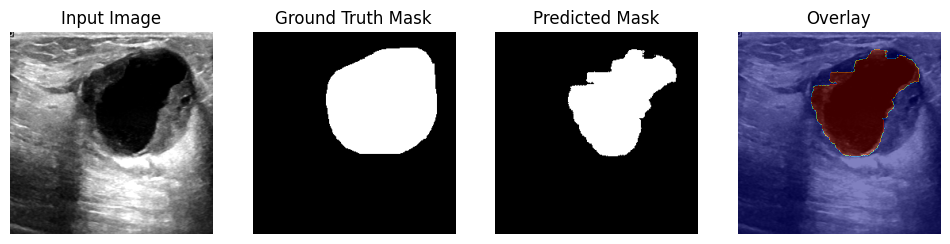

In [ ]:
# Segmentation Testing:

def plot_segmentation_results(images, masks_true, masks_pred, n=10):
    for i in range(n):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 4, 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(masks_true[i].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(masks_pred[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(images[i], cmap='gray')
        plt.imshow(masks_pred[i], cmap='jet', alpha=0.5)
        plt.title("Overlay")
        plt.axis('off')

        plt.show()


pred_masks, _ = model.predict(X_val, verbose=0)
seg_masks_bin = (pred_masks > 0.5).astype(np.uint8)
plot_segmentation_results(X_val, y_val_mask, seg_masks_bin)

5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step

📊 Classification Report (Validation Set):
              precision    recall  f1-score   support

      normal       0.51      0.78      0.62        27
      benign       0.78      0.77      0.77        87
   malignant       0.79      0.55      0.65        42

    accuracy                           0.71       156
   macro avg       0.69      0.70      0.68       156
weighted avg       0.74      0.71      0.71       156


📈 Classification Metrics (Training Set):
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step
Accuracy:  0.7596
Precision: 0.8009
Recall:    0.7596
F1-score:  0.7611

📈 Classification Metrics (Validation Set):
Accuracy:  0.7115
Precision: 0.7367
Recall:    0.7115
F1-score:  0.7133


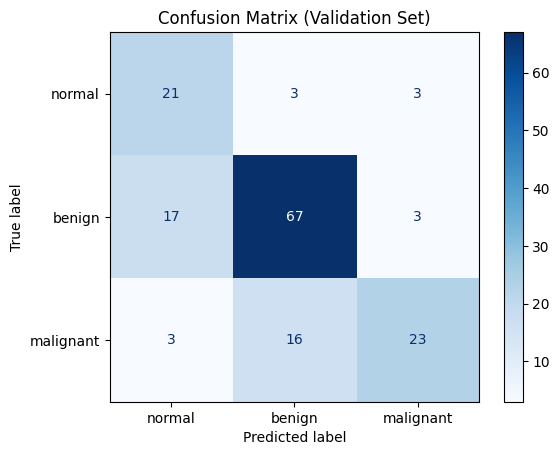

20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step

🧠 Segmentation Metrics (Training Set):
Average Dice Coefficient: 0.5802
Average IoU:              0.3650
Average Pixel Accuracy:   0.9482
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step

🧠 Segmentation Metrics (Validation Set):
Average Dice Coefficient: 0.5942
Average IoU:              0.3879
Average Pixel Accuracy:   0.9510


In [ ]:
#Evaluation Metrics

# Predict classification probabilities
_, cls_preds_val = model.predict(X_val)
cls_preds_labels_val = cls_preds_val.argmax(axis=1)

print("\n📊 Classification Report (Validation Set):")
print(classification_report(y_val_cls, cls_preds_labels_val, target_names=classes))

# ----------- Classification Metrics (Training) -------------
print("\n📈 Classification Metrics (Training Set):")
y_true_train = y_train_cls
y_pred_probs_train = model.predict(X_train)[1]
y_pred_train = np.argmax(y_pred_probs_train, axis=1)

acc_train = accuracy_score(y_true_train, y_pred_train)
precision_train = precision_score(y_true_train, y_pred_train, average='weighted')
recall_train = recall_score(y_true_train, y_pred_train, average='weighted')
f1_train = f1_score(y_true_train, y_pred_train, average='weighted')

print(f'Accuracy:  {acc_train:.4f}')
print(f'Precision: {precision_train:.4f}')
print(f'Recall:    {recall_train:.4f}')
print(f'F1-score:  {f1_train:.4f}')

# ----------- Classification Metrics (Validation) -------------
print("\n📈 Classification Metrics (Validation Set):")
acc_val = accuracy_score(y_val_cls, cls_preds_labels_val)
precision_val = precision_score(y_val_cls, cls_preds_labels_val, average='weighted')
recall_val = recall_score(y_val_cls, cls_preds_labels_val, average='weighted')
f1_val = f1_score(y_val_cls, cls_preds_labels_val, average='weighted')

print(f'Accuracy:  {acc_val:.4f}')
print(f'Precision: {precision_val:.4f}')
print(f'Recall:    {recall_val:.4f}')
print(f'F1-score:  {f1_val:.4f}')

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_val_cls, cls_preds_labels_val, display_labels=classes, cmap='Blues')
plt.title('Confusion Matrix (Validation Set)')
plt.show()


# ---------- Segmentation Metrics ----------
def dice_coef_np(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-7) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1e-7)

def iou_np(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(np.clip(y_true_f + y_pred_f, 0, 1))
    return intersection / (union + 1e-7)

def pixel_accuracy_np(y_true, y_pred):
    return np.mean((y_true == y_pred).astype(np.float32))

# ----------- Segmentation Metrics (Training) -------------
seg_preds_train = model.predict(X_train)[0]
seg_preds_train_bin = (seg_preds_train > 0.5).astype(np.uint8)

dice_train, iou_train, pixel_train = [], [], []
for i in range(len(y_train_mask)):
    dice_train.append(dice_coef_np(y_train_mask[i].squeeze(), seg_preds_train_bin[i].squeeze()))
    iou_train.append(iou_np(y_train_mask[i].squeeze(), seg_preds_train_bin[i].squeeze()))
    pixel_train.append(pixel_accuracy_np(y_train_mask[i].squeeze(), seg_preds_train_bin[i].squeeze()))

print("\n🧠 Segmentation Metrics (Training Set):")
print(f"Average Dice Coefficient: {np.mean(dice_train):.4f}")
print(f"Average IoU:              {np.mean(iou_train):.4f}")
print(f"Average Pixel Accuracy:   {np.mean(pixel_train):.4f}")

# ----------- Segmentation Metrics (Validation) -------------
seg_preds_val = model.predict(X_val)[0]
seg_preds_val_bin = (seg_preds_val > 0.5).astype(np.uint8)

dice_val, iou_val, pixel_val = [], [], []
for i in range(len(y_val_mask)):
    dice_val.append(dice_coef_np(y_val_mask[i].squeeze(), seg_preds_val_bin[i].squeeze()))
    iou_val.append(iou_np(y_val_mask[i].squeeze(), seg_preds_val_bin[i].squeeze()))
    pixel_val.append(pixel_accuracy_np(y_val_mask[i].squeeze(), seg_preds_val_bin[i].squeeze()))

print("\n🧠 Segmentation Metrics (Validation Set):")
print(f"Average Dice Coefficient: {np.mean(dice_val):.4f}")
print(f"Average IoU:              {np.mean(iou_val):.4f}")
print(f"Average Pixel Accuracy:   {np.mean(pixel_val):.4f}")


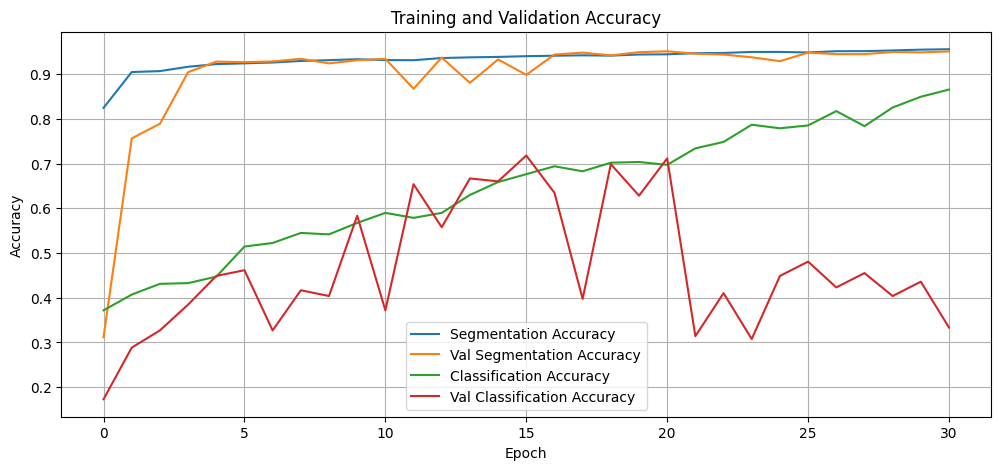

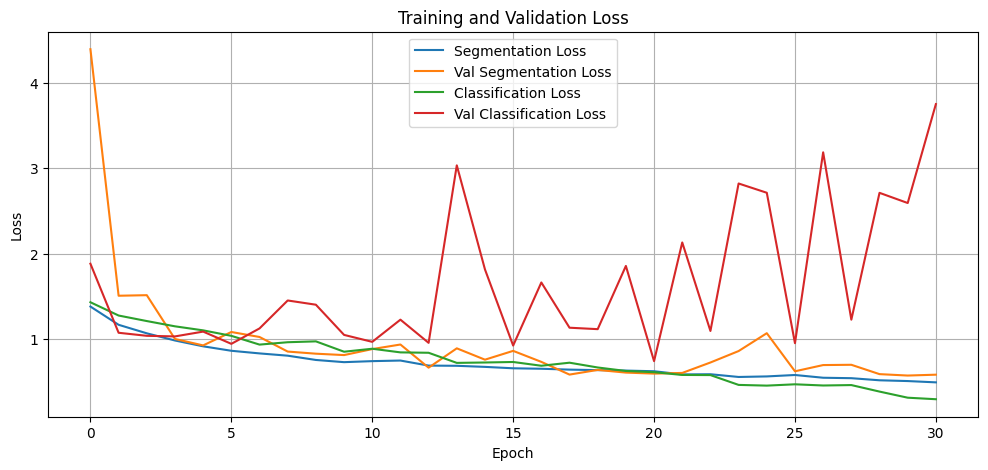

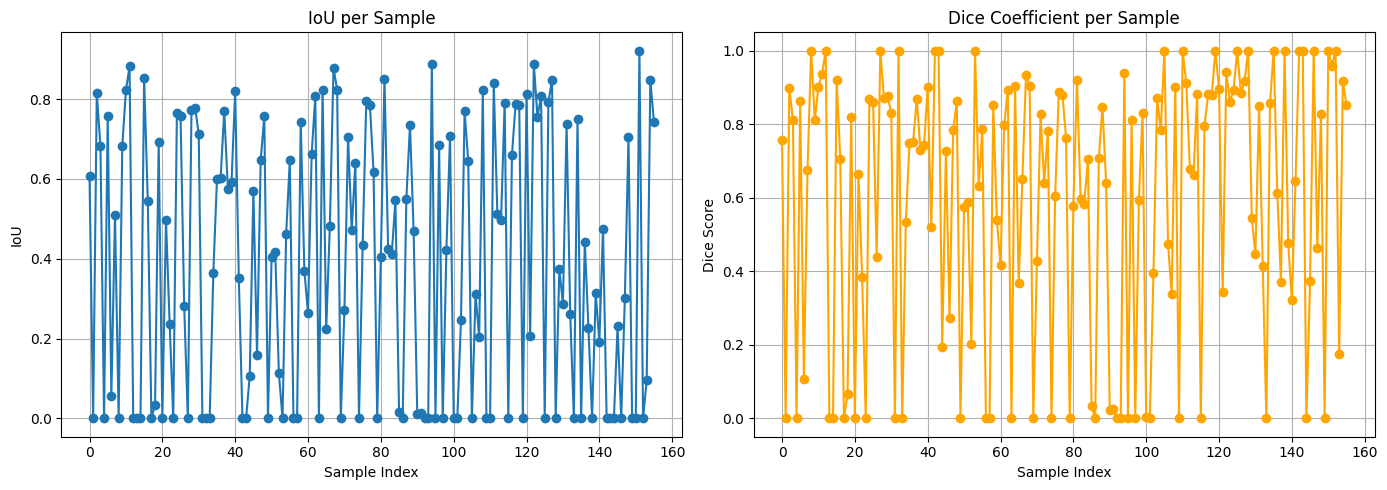

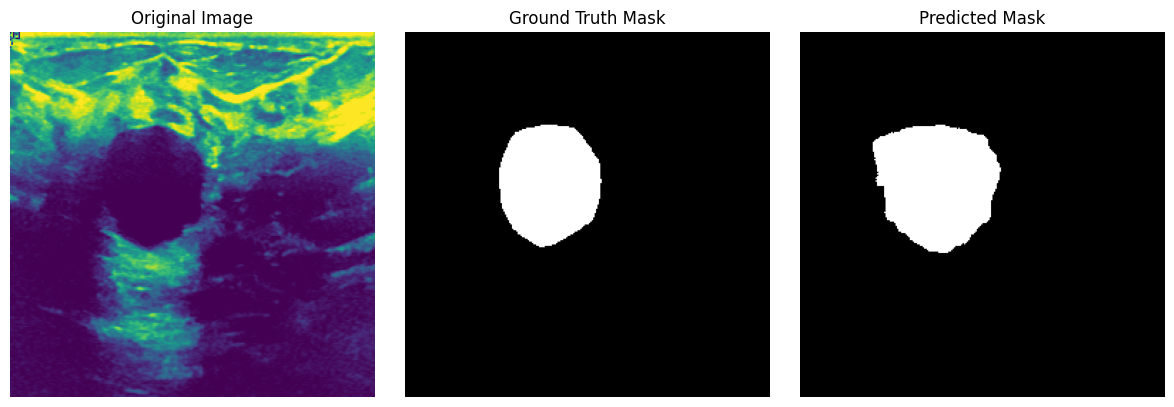

In [ ]:
#Visualizations:

# Plot accuracy curves
plt.figure(figsize=(12, 5))
plt.plot(history.history['segmentation_accuracy'], label='Segmentation Accuracy')
plt.plot(history.history['val_segmentation_accuracy'], label='Val Segmentation Accuracy')
plt.plot(history.history['classification_accuracy'], label='Classification Accuracy')
plt.plot(history.history['val_classification_accuracy'], label='Val Classification Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
print("\n")

# Plot training & validation loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['segmentation_loss'], label='Segmentation Loss')
plt.plot(history.history['val_segmentation_loss'], label='Val Segmentation Loss')
plt.plot(history.history['classification_loss'], label='Classification Loss')
plt.plot(history.history['val_classification_loss'], label='Val Classification Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
print("\n")

# Plot IoU and Dice per sample
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(iou_val, marker='o')
plt.title('IoU per Sample')
plt.xlabel('Sample Index')
plt.ylabel('IoU')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(dice_val, marker='o', color='orange')
plt.title('Dice Coefficient per Sample')
plt.xlabel('Sample Index')
plt.ylabel('Dice Score')
plt.grid(True)
plt.tight_layout()
plt.show()
print("\n")
ix = random.randint(0, len(X_val) - 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(X_val[ix])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(y_val_mask[ix].squeeze(), cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(seg_preds_val_bin[ix].squeeze(), cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

Testing: 03.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


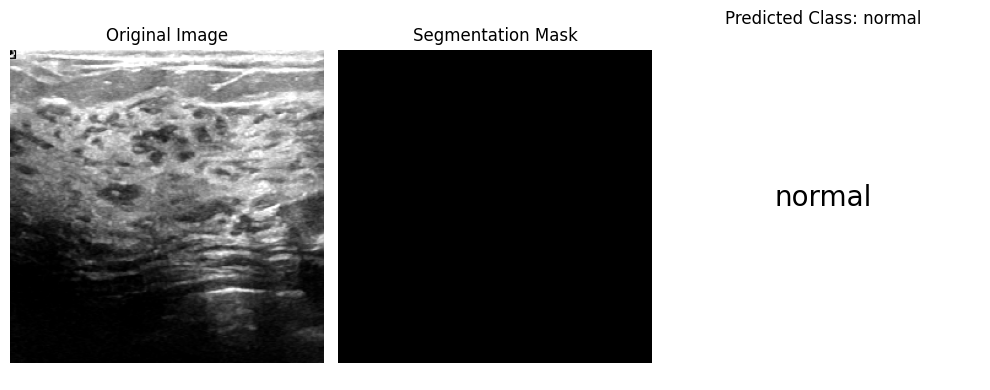

Testing: 02.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


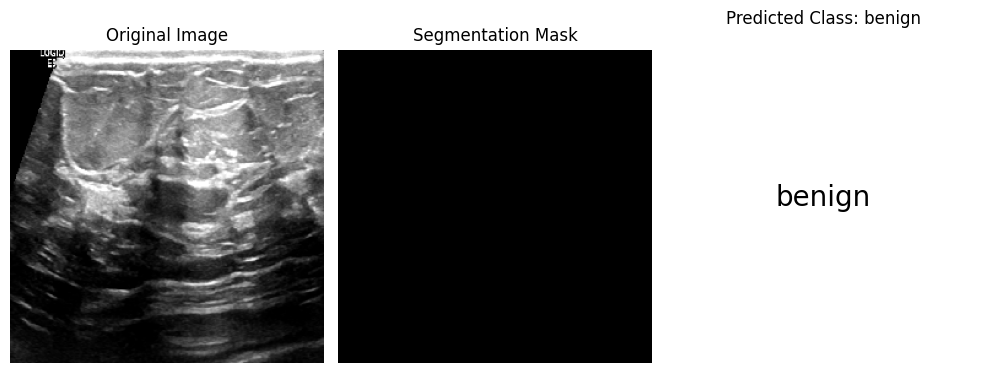

Testing: 01.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


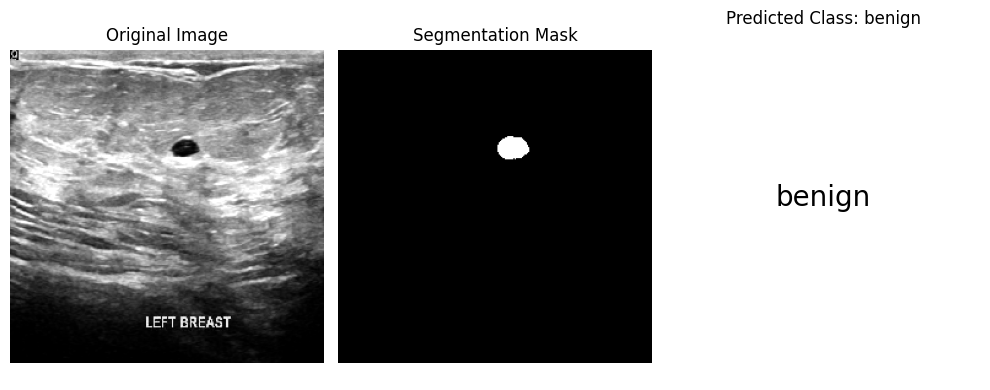

Testing: 04.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


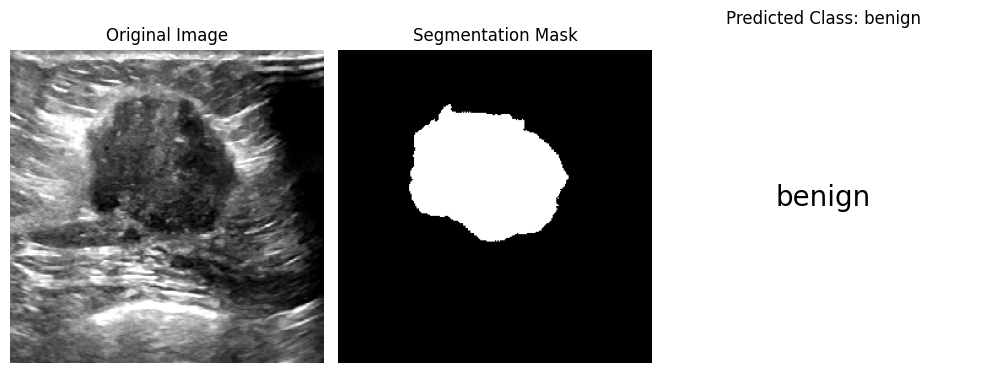

In [ ]:
# Live Test:

IMAGE_DIR = "/kaggle/input/busi-dataset/Dataset BUSI/Live Test"
IMG_HEIGHT = 256
IMG_WIDTH = 256
CLASS_NAMES = ['normal', 'benign', 'malignant']

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
    img = contrast_stretching(img)
    img = log_contrast_stretching(img)
    img = apply_gamma_correction(img)
    img_array = img_to_array(img) / 255.0
    return img_array

def predict_and_display(model, image_path):
    img_array = preprocess_image(image_path)
    input_tensor = np.expand_dims(img_array, axis=0)

    # Predict
    seg_pred, class_pred = model.predict(input_tensor)
    seg_mask = seg_pred[0, :, :, 0] > 0.5
    class_label = CLASS_NAMES[np.argmax(class_pred[0])]

    # Display
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img_array.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Segmentation Mask")
    plt.imshow(seg_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"Predicted Class: {class_label}")
    plt.text(0.5, 0.5, class_label, fontsize=20, ha='center')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Live Predictions
image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]
for image_name in image_files:
    print(f"Testing: {image_name}")
    predict_and_display(model, os.path.join(IMAGE_DIR, image_name))


In [ ]:
# Grad-CAM Visualization

last_conv_layer_name = "conv2d_219"  # replace with actual name from c5
grad_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=[
        model.get_layer(last_conv_layer_name).output,
        model.get_layer("classification").output
    ]
)

def compute_gradcam(image, class_index=None):
    img_tensor = tf.expand_dims(image, axis=0)  # Add batch dimension

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        tape.watch(conv_outputs)

        if class_index is None:
            class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    if grads is None:
        raise ValueError("Gradients are None. Check model connectivity.")

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy(), class_index.numpy()

def load_image_grayscale(path, size=(256, 256)):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)  # Grayscale
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size)
    return img

def show_gradcam_overlay(image, heatmap, class_name):
    image_uint8 = (image.numpy() * 255).astype(np.uint8)
    image_rgb = np.repeat(image_uint8, 3, axis=-1)  # Convert grayscale to RGB

    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    superimposed = cv2.addWeighted(image_rgb, 0.6, heatmap_color, 0.4, 0)

    # Show with matplotlib
    plt.figure(figsize=(6, 6))
    plt.imshow(superimposed)
    plt.title(f"Grad-CAM: {class_name}")
    plt.axis("off")
    plt.show()

# Example
img_path = "/kaggle/input/busi-dataset/Dataset BUSI/Live Test/04.png"
image = load_image_grayscale(img_path, size=(256, 256))

heatmap, pred_class = compute_gradcam(image)
class_name = classes[pred_class]

show_gradcam_overlay(image, heatmap, class_name)



ValueError: No such layer: conv2d_219. Existing layers are: ['input_layer', 'conv2d', 'batch_normalization', 're_lu', 'dropout', 'conv2d_1', 'batch_normalization_1', 're_lu_1', 'max_pooling2d', 'conv2d_2', 'batch_normalization_2', 're_lu_2', 'dropout_1', 'conv2d_3', 'batch_normalization_3', 're_lu_3', 'max_pooling2d_1', 'conv2d_4', 'batch_normalization_4', 're_lu_4', 'dropout_2', 'conv2d_5', 'batch_normalization_5', 're_lu_5', 'max_pooling2d_2', 'conv2d_6', 'batch_normalization_6', 're_lu_6', 'dropout_3', 'conv2d_7', 'batch_normalization_7', 're_lu_7', 'max_pooling2d_3', 'conv2d_8', 'batch_normalization_8', 're_lu_8', 'dropout_4', 'conv2d_9', 'batch_normalization_9', 're_lu_9', 'conv2d_transpose', 'conv2d_10', 'conv2d_11', 'add', 'activation', 'conv2d_12', 'activation_1', 'multiply', 'concatenate', 'conv2d_13', 'batch_normalization_10', 're_lu_10', 'dropout_5', 'conv2d_14', 'batch_normalization_11', 're_lu_11', 'conv2d_transpose_1', 'conv2d_15', 'conv2d_16', 'add_1', 'activation_2', 'conv2d_17', 'activation_3', 'multiply_1', 'concatenate_1', 'conv2d_18', 'batch_normalization_12', 're_lu_12', 'dropout_6', 'conv2d_19', 'batch_normalization_13', 're_lu_13', 'conv2d_transpose_2', 'conv2d_20', 'conv2d_21', 'add_2', 'activation_4', 'conv2d_22', 'activation_5', 'multiply_2', 'concatenate_2', 'conv2d_23', 'batch_normalization_14', 're_lu_14', 'dropout_7', 'conv2d_24', 'batch_normalization_15', 're_lu_15', 'conv2d_transpose_3', 'conv2d_25', 'conv2d_26', 'add_3', 'activation_6', 'conv2d_27', 'activation_7', 'multiply_3', 'concatenate_3', 'conv2d_28', 'batch_normalization_16', 'global_average_pooling2d', 're_lu_16', 'dense', 'dropout_8', 'batch_normalization_18', 'conv2d_29', 'dropout_9', 'batch_normalization_17', 'dense_1', 're_lu_17', 'dropout_10', 'segmentation', 'classification'].

In [ ]:
# Saliency Map Visual:

def compute_saliency_map(image, class_index=None):
    img_tensor = tf.expand_dims(image, axis=0)  # Add batch dim

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor, training=False)[1]  # Classification output (index 1)

        if class_index is None:
            class_index = tf.argmax(preds[0])
        loss = preds[:, class_index]

    grads = tape.gradient(loss, img_tensor)[0]  # Shape: (H, W, C)

    # Take max magnitude across color channels (if grayscale C=1, so just squeeze)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)

    # Normalize to [0, 1]
    saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency) + 1e-8)

    return saliency.numpy()

def show_saliency(image, saliency_map, class_name):
    image_uint8 = (image.numpy() * 255).astype(np.uint8)
    image_rgb = np.repeat(image_uint8, 3, axis=-1)  # grayscale to RGB

    saliency_uint8 = np.uint8(255 * saliency_map)
    saliency_color = cv2.applyColorMap(saliency_uint8, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(image_rgb, 0.6, saliency_color, 0.4, 0)

    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.title(f"Saliency Map: {class_name}")
    plt.axis('off')
    plt.show()
img_path = "/kaggle/input/busi-dataset/Dataset BUSI/Live Test/01.png"
image = load_image_grayscale(img_path, size=(256, 256))

heatmap, pred_class = compute_gradcam(image)
saliency = compute_saliency_map(image, pred_class)
class_name = CLASS_NAMES[pred_class]

# Show Saliency Map
show_saliency(image, saliency, class_name)


In [ ]:
# BiFPN Network (from EfficientDet):

from tensorflow.keras import layers, models, backend as K

IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 1
NUM_CLASSES_CLASSIFICATION = 3
NUM_FPN_FILTERS = 64
FPN_CELL_REPEATS = 2

class_weights_tensor = tf.constant([2.0, 1.0, 1.5], dtype=tf.float32)

def conv_block(input_tensor, n_filters, dropout_rate=0.1):
    x = layers.Conv2D(n_filters, (3, 3), padding="same", kernel_initializer="he_normal")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv2D(n_filters, (3, 3), padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def attention_gate(x, g, inter_channels):
    # Linear transformations for x and g
    theta_x = layers.Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = layers.Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(g)

    # Add transformed features
    add = layers.Add()([theta_x, phi_g])
    relu = layers.Activation('relu')(add)

    # Generate attention coefficients
    psi = layers.Conv2D(1, (1, 1), padding='same')(relu)
    sigmoid = layers.Activation('sigmoid')(psi)

    # Multiply attention map with the encoder features
    out = layers.Multiply()([x, sigmoid])
    return out

def resample_feature_map(feat, target_height, target_width, target_num_channels):
    _, height, width, num_channels = list(feat.shape)

    if num_channels != target_num_channels:
        # Apply 1x1 conv to change layer width if necessary (channel adjustment)
        feat = layers.Conv2D(target_num_channels, (1, 1), padding='same',
                             kernel_initializer="he_normal")(feat)
        feat = layers.BatchNormalization()(feat) # Apply BN after 1x1 conv

    if height > target_height or width > target_width:
        if height > target_height and width > target_width:
            # Calculate pool size to roughly match target size
            height_stride = max(1, int(round(height / target_height)))
            width_stride = max(1, int(round(width / target_width)))
            feat = layers.MaxPooling2D(pool_size=(height_stride, width_stride),
                                       strides=(height_stride, width_stride),
                                       padding='same')(feat)
        if feat.shape[1] is not None and feat.shape[2] is not None and (feat.shape[1] != target_height or feat.shape[2] != target_width):
            feat = layers.Lambda(lambda x: tf.image.resize(x, [target_height, target_width], method=tf.image.ResizeMethod.BILINEAR))(feat)

    elif height < target_height or width < target_width:
        feat = layers.Lambda(lambda x: tf.image.resize(x, [target_height, target_width], method=tf.image.ResizeMethod.BILINEAR))(feat)

    return feat

def fuse_features(nodes, weight_method='fastattn'):
    if weight_method == 'fastattn':
        relu_weights_list = [tf.constant(1.0, dtype=tf.float32) for _ in nodes]
        weights_sum = tf.add_n(relu_weights_list) + 1e-4 # Add epsilon for stability
        normalized_nodes = [
            layers.Lambda(lambda x, w=relu_weights_list[i], s=weights_sum: x * w / s)(nodes[i])
            for i in range(len(nodes))
        ]
        new_node = layers.Add()(normalized_nodes) # Use layers.Add for KerasTensors
    elif weight_method == 'sum':
        new_node = layers.Add()(nodes) # Simple sum
    else:
        raise ValueError(f'Unsupported weight_method: {weight_method}')

    return new_node

def build_bifpn_cell(features, fpn_num_filters, min_level, max_level):
    # Create a list of feature maps, ordered by level
    feats_list_ordered = [features[level] for level in sorted(features.keys())]

    # Target heights/widths for each level based on encoder outputs
    target_sizes = {}
    for i, level in enumerate(sorted(features.keys())):
        current_shape = feats_list_ordered[i].shape
        target_sizes[level] = [current_shape[1], current_shape[2]]

    # Ensure P6 and P7 target sizes are derived correctly from P5 if not initially present
    if 5 in target_sizes:
        if 6 not in target_sizes:
            target_sizes[6] = [s // 2 for s in target_sizes[5]]
        if 7 not in target_sizes:
            target_sizes[7] = [s // 4 for s in target_sizes[5]]
    nodes = {}
    for level in range(min_level, max_level + 1):
        if level in features and features[level] is not None:
            nodes[level] = resample_feature_map(features[level], *target_sizes[level], fpn_num_filters)
        else:

            pass

    p7_in_td = nodes.get(7)
    p6_upsampled_td_to_p7 = resample_feature_map(nodes.get(6), *target_sizes[7], fpn_num_filters) if 6 in nodes and nodes[6] is not None else None

    if p7_in_td is not None and p6_upsampled_td_to_p7 is not None:
        nodes['p7_td'] = fuse_features([p7_in_td, p6_upsampled_td_to_p7])
    elif p7_in_td is not None:
        nodes['p7_td'] = p7_in_td # Fallback if only P7 is available
    elif p6_upsampled_td_to_p7 is not None:
        nodes['p7_td'] = p6_upsampled_td_to_p7 # Fallback if only upsampled P6 is available
    else:
        nodes['p7_td'] = None # Should not happen if P5, P6, P7 are properly initialized

    p6_in_td = nodes.get(6)
    p5_upsampled_td_to_p6 = resample_feature_map(nodes.get(5), *target_sizes[6], fpn_num_filters) if 5 in nodes and nodes[5] is not None else None
    p7_td_upsampled_to_p6 = resample_feature_map(nodes.get('p7_td'), *target_sizes[6], fpn_num_filters) if 'p7_td' in nodes and nodes['p7_td'] is not None else None

    p6_td_inputs = [x for x in [p6_in_td, p5_upsampled_td_to_p6, p7_td_upsampled_to_p6] if x is not None]
    if p6_td_inputs:
        nodes['p6_td'] = fuse_features(p6_td_inputs)
    else:
        nodes['p6_td'] = None # Fallback

    p5_in_td = nodes.get(5)
    p4_upsampled_td_to_p5 = resample_feature_map(nodes.get(4), *target_sizes[5], fpn_num_filters) if 4 in nodes and nodes[4] is not None else None
    p6_td_upsampled_to_p5 = resample_feature_map(nodes.get('p6_td'), *target_sizes[5], fpn_num_filters) if 'p6_td' in nodes and nodes['p6_td'] is not None else None

    p5_td_inputs = [x for x in [p5_in_td, p4_upsampled_td_to_p5, p6_td_upsampled_to_p5] if x is not None]
    if p5_td_inputs:
        nodes['p5_td'] = fuse_features(p5_td_inputs)
    else:
        nodes['p5_td'] = None # Fallback
    p4_in_td = nodes.get(4)
    p3_upsampled_td_to_p4 = resample_feature_map(nodes.get(3), *target_sizes[4], fpn_num_filters) if 3 in nodes and nodes[3] is not None else None
    p5_td_upsampled_to_p4 = resample_feature_map(nodes.get('p5_td'), *target_sizes[4], fpn_num_filters) if 'p5_td' in nodes and nodes['p5_td'] is not None else None

    p4_td_inputs = [x for x in [p4_in_td, p3_upsampled_td_to_p4, p5_td_upsampled_to_p4] if x is not None]
    if p4_td_inputs:
        nodes['p4_td'] = fuse_features(p4_td_inputs)
    else:
        nodes['p4_td'] = None # Fallback


    # P3_td
    # Inputs: P3_in, P4_td (upsampled)
    p3_in_td = nodes.get(3)
    p4_td_upsampled_to_p3 = resample_feature_map(nodes.get('p4_td'), *target_sizes[3], fpn_num_filters) if 'p4_td' in nodes and nodes['p4_td'] is not None else None

    p3_td_inputs = [x for x in [p3_in_td, p4_td_upsampled_to_p3] if x is not None]
    if p3_td_inputs:
        nodes['p3_td'] = fuse_features(p3_td_inputs)
    else:
        nodes['p3_td'] = None # Fallback


    # --- Bottom-up pathway (e.g., P3_bu -> P4_bu -> P5_bu -> P6_bu -> P7_bu) ---

    # P3_bu is typically just P3_td
    nodes['p3_bu'] = nodes.get('p3_td') # Directly use P3_td as the first bottom-up node


    # P4_bu
    # Inputs: P4_in, P4_td, P3_bu (downsampled)
    p4_in_bu = nodes.get(4)
    p4_td_bu = nodes.get('p4_td')
    p3_bu_downsampled_to_p4 = resample_feature_map(nodes.get('p3_bu'), *target_sizes[4], fpn_num_filters) if 'p3_bu' in nodes and nodes['p3_bu'] is not None else None

    p4_bu_inputs = [x for x in [p4_in_bu, p4_td_bu, p3_bu_downsampled_to_p4] if x is not None]
    if p4_bu_inputs:
        nodes['p4_bu'] = fuse_features(p4_bu_inputs)
    else:
        nodes['p4_bu'] = None # Fallback


    # P5_bu
    # Inputs: P5_in, P5_td, P4_bu (downsampled)
    p5_in_bu = nodes.get(5)
    p5_td_bu = nodes.get('p5_td')
    p4_bu_downsampled_to_p5 = resample_feature_map(nodes.get('p4_bu'), *target_sizes[5], fpn_num_filters) if 'p4_bu' in nodes and nodes['p4_bu'] is not None else None

    p5_bu_inputs = [x for x in [p5_in_bu, p5_td_bu, p4_bu_downsampled_to_p5] if x is not None]
    if p5_bu_inputs:
        nodes['p5_bu'] = fuse_features(p5_bu_inputs)
    else:
        nodes['p5_bu'] = None # Fallback


    # P6_bu
    # Inputs: P6_in, P6_td, P5_bu (downsampled)
    p6_in_bu = nodes.get(6)
    p6_td_bu = nodes.get('p6_td')
    p5_bu_downsampled_to_p6 = resample_feature_map(nodes.get('p5_bu'), *target_sizes[6], fpn_num_filters) if 'p5_bu' in nodes and nodes['p5_bu'] is not None else None

    p6_bu_inputs = [x for x in [p6_in_bu, p6_td_bu, p5_bu_downsampled_to_p6] if x is not None]
    if p6_bu_inputs:
        nodes['p6_bu'] = fuse_features(p6_bu_inputs)
    else:
        nodes['p6_bu'] = None # Fallback


    # P7_bu
    # Inputs: P7_in, P7_td, P6_bu (downsampled)
    p7_in_bu = nodes.get(7)
    p7_td_bu = nodes.get('p7_td')
    p6_bu_downsampled_to_p7 = resample_feature_map(nodes.get('p6_bu'), *target_sizes[7], fpn_num_filters) if 'p6_bu' in nodes and nodes['p6_bu'] is not None else None

    p7_bu_inputs = [x for x in [p7_in_bu, p7_td_bu, p6_bu_downsampled_to_p7] if x is not None]
    if p7_bu_inputs:
        nodes['p7_bu'] = fuse_features(p7_bu_inputs)
    else:
        nodes['p7_bu'] = None # Fallback


    # Final outputs are the bottom-up pathway outputs
    final_features = {}
    for level in range(min_level, max_level + 1):
        if f'{level}_bu' in nodes and nodes[f'{level}_bu'] is not None:
            final_features[level] = nodes[f'{level}_bu']
        elif f'{level}_td' in nodes and nodes[f'{level}_td'] is not None:
            final_features[level] = nodes[f'{level}_td'] # Fallback to top-down if no bottom-up
        elif level in nodes and nodes[level] is not None:
            final_features[level] = nodes[level] # Fallback to initial feature if no FPN processing

    return final_features


def build_multi_task_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=NUM_CLASSES_CLASSIFICATION):
    """
    Builds a Multi-Task U-Net model with a BiFPN-like decoder.
    """
    inputs = layers.Input(shape=input_shape)

    # Encoder (U-Net style)
    c1 = conv_block(inputs, 16)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 32)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 64, dropout_rate=0.2) # Level 3 (P3) - (64x64)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 128, dropout_rate=0.2) # Level 4 (P4) - (32x32)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck (P5) - (16x16)
    c5 = conv_block(p4, 256, dropout_rate=0.3)

    # Prepare initial features for BiFPN: P3, P4, P5 from encoder
    # and P6, P7 derived from P5.

    bifpn_input_features = {
        3: c3, # (64x64)
        4: c4, # (32x32)
        5: c5  # (16x16)
    }
    target_h_p6, target_w_p6 = c5.shape[1] // 2, c5.shape[2] // 2 # 8x8
    p6_from_c5 = resample_feature_map(c5, target_h_p6, target_w_p6, NUM_FPN_FILTERS)
    bifpn_input_features[6] = p6_from_c5

    target_h_p7, target_w_p7 = c5.shape[1] // 4, c5.shape[2] // 4 # 4x4
    p7_from_c5 = resample_feature_map(c5, target_h_p7, target_w_p7, NUM_FPN_FILTERS)
    bifpn_input_features[7] = p7_from_c5

    # Build BiFPN layers iteratively
    bifpn_features = bifpn_input_features
    for _ in range(FPN_CELL_REPEATS):
        bifpn_features = build_bifpn_cell(bifpn_features, NUM_FPN_FILTERS, 3, 7) # min_level, max_level

    # Segmentation output - needs to be upsampled to IMG_HEIGHT x IMG_WIDTH
    final_seg_feature = None
    if 3 in bifpn_features and bifpn_features[3] is not None:
        final_seg_feature = bifpn_features[3]
    else:
        print("Warning: P3_bu not found in BiFPN features for segmentation, falling back to c3.")
        final_seg_feature = c3

    # Upsample the final segmentation feature to original image size (256x256)
    upsampled_seg_feature = resample_feature_map(final_seg_feature, IMG_HEIGHT, IMG_WIDTH, NUM_FPN_FILTERS)
    seg_output = layers.Conv2D(1, (1, 1), activation='sigmoid', name='segmentation')(upsampled_seg_feature)


    # Classification head - typically uses a global feature from a higher level, like P5_bu
    classification_input = None
    if 5 in bifpn_features and bifpn_features[5] is not None:
        classification_input = bifpn_features[5]
    else:
        print("Warning: P5_bu not found in BiFPN features for classification, falling back to c5.")
        classification_input = c5

    gap = layers.GlobalAveragePooling2D()(classification_input)
    dense1 = layers.Dense(256, activation='relu')(gap)
    bn1 = layers.BatchNormalization()(dense1)
    drop1 = layers.Dropout(0.5)(bn1)
    dense2 = layers.Dense(128, activation='relu')(drop1)
    drop2 = layers.Dropout(0.3)(dense2)
    class_output = layers.Dense(num_classes, activation='softmax', name='classification')(drop2)

    model = models.Model(inputs=[inputs], outputs=[seg_output, class_output])
    return model

# Loss functions
def weighted_sparse_categorical_crossentropy(class_weights_tensor):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        weights = tf.gather(class_weights_tensor, y_true)
        unweighted_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        weighted_loss = unweighted_loss * weights
        return tf.reduce_mean(weighted_loss)
    return loss_fn

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    denom = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return 1 - (2. * intersection + smooth) / (denom + smooth)

def combined_segmentation_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Build, compile, and summarize the model
model = build_multi_task_unet()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss={
        'segmentation': combined_segmentation_loss,
        'classification': weighted_sparse_categorical_crossentropy(class_weights_tensor)
    },
    loss_weights={'segmentation': 0.6, 'classification': 1.0},
    metrics={
        'segmentation': ['accuracy', dice_loss],
        'classification': ['accuracy']
    }
)

model.summary()


# Best Result:

# Training:---

# Accuracy:  0.9151
# Precision: 0.9295
# Recall:    0.9151
# F1-score:  0.9157
# Average Dice Coefficient: 0.8636
# Average IoU:              0.6283
# Average Pixel Accuracy:   0.9836

# Testing:---

# Accuracy:  0.7692
# Precision: 0.7928
# Recall:    0.7692
# F1-score:  0.7722
# Average Dice Coefficient: 0.6666
# Average IoU:              0.4439
# Average Pixel Accuracy:   0.9583

# Accuracy:------- 76.92%